In [ ]:
# Uneccessary on google colab
# %conda install pytorch torchvision -c pytorch
# %conda install -c fastai fastai

In [11]:
from fastai.vision.all import *
from fastcore.all import *
from fastai.callback.tracker import EarlyStoppingCallback

## Cat v dog single-label classification example

### Label dataset

In [ ]:
path = untar_data(URLs.PETS)
file_names = get_image_files(path/'images')

def label_func(filename):
    return "cat" if filename.name[0].isupper() else "dog"

dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

dls = dblock.dataloaders(path/"images")
dls.show_batch()

### Retraining ResNet34 on new labeled dataset

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

### Test the performance of retrained model

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
img = PILImage.create(file_names[9])

prediction,_,probs = learn.predict(img)

print(f"Predicted animal: {prediction}.")
print(f"Probability it is this animal: {probs[1].item():.6f}")
img.to_thumb(192)

## Retrain for single-label Chest cancer classification

In [2]:
!git clone https://github.com/davay/data5100.git

Cloning into 'data5100'...
remote: Enumerating objects: 930, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 930 (delta 14), reused 7 (delta 1), pack-reused 902
Receiving objects: 100% (930/930), 89.29 MiB | 31.74 MiB/s, done.
Resolving deltas: 100% (21/21), done.


### Label and load images

In [3]:
path = 'data5100/data'
dls = ImageDataLoaders.from_folder(path,
                            train = 'train',
                            valid = 'valid',
                            test = 'test',
                            item_tfms = Resize(450, pad_mode='zeros'),
                            # item_tfms = RandomResizedCrop(450, min_scale = 0.75), # imagenet models often use 224 x 224. Our images aren't 1:1 aspect ratio, by default center crop will be used. We can add pad_mode='zeros' for no cropping.
                            batch_tfms=[*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)])

### Test the accuracy of stock imagenet model

In [ ]:
# TODO: IN PROGRESS

# model = resnet34(pretrained = True)

# # switch to evaluation mode for inference rather than training
# model.eval()

### Retrain model on new data set

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 118MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.330402,2.172642,0.611111,00:08
1,2.111604,1.987003,0.555556,00:06
2,1.870713,1.707874,0.500000,00:08
3,1.644204,1.524405,0.541667,00:06
4,1.475264,1.146642,0.416667,00:09
5,1.284120,0.687951,0.375000,00:06
6,1.137715,0.825119,0.361111,00:07
7,0.988304,0.719019,0.347222,00:06
8,0.890041,0.680273,0.319444,00:07


No improvement since epoch 5: early stopping


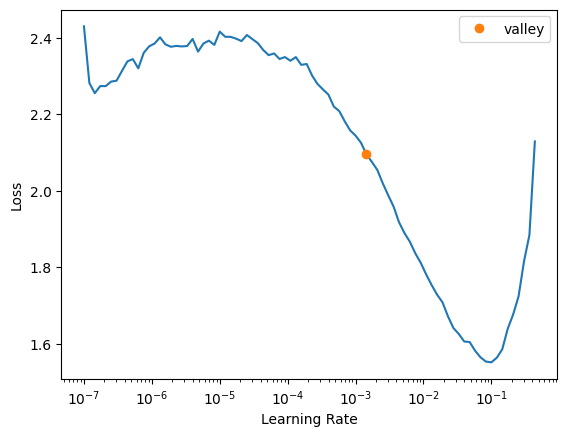

In [19]:
learn = vision_learner(dls, densenet121, metrics=error_rate)
lr_valley = learn.lr_find().valley
epoch = 30
learn.fit_one_cycle(epoch, lr_valley, cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)])

### Test the accuracy of retrained model

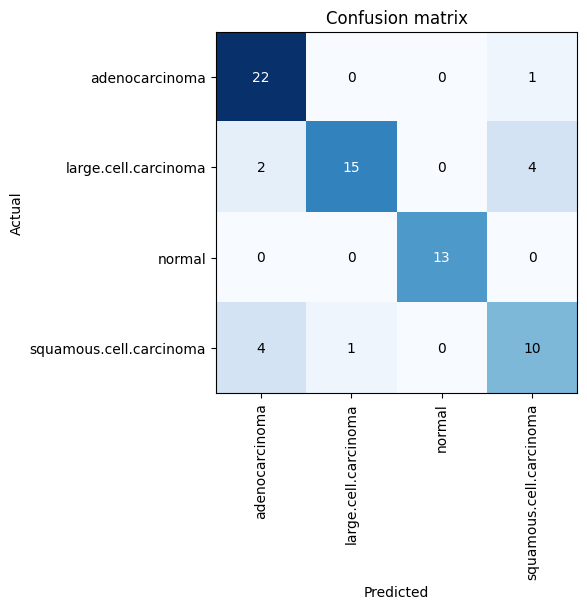

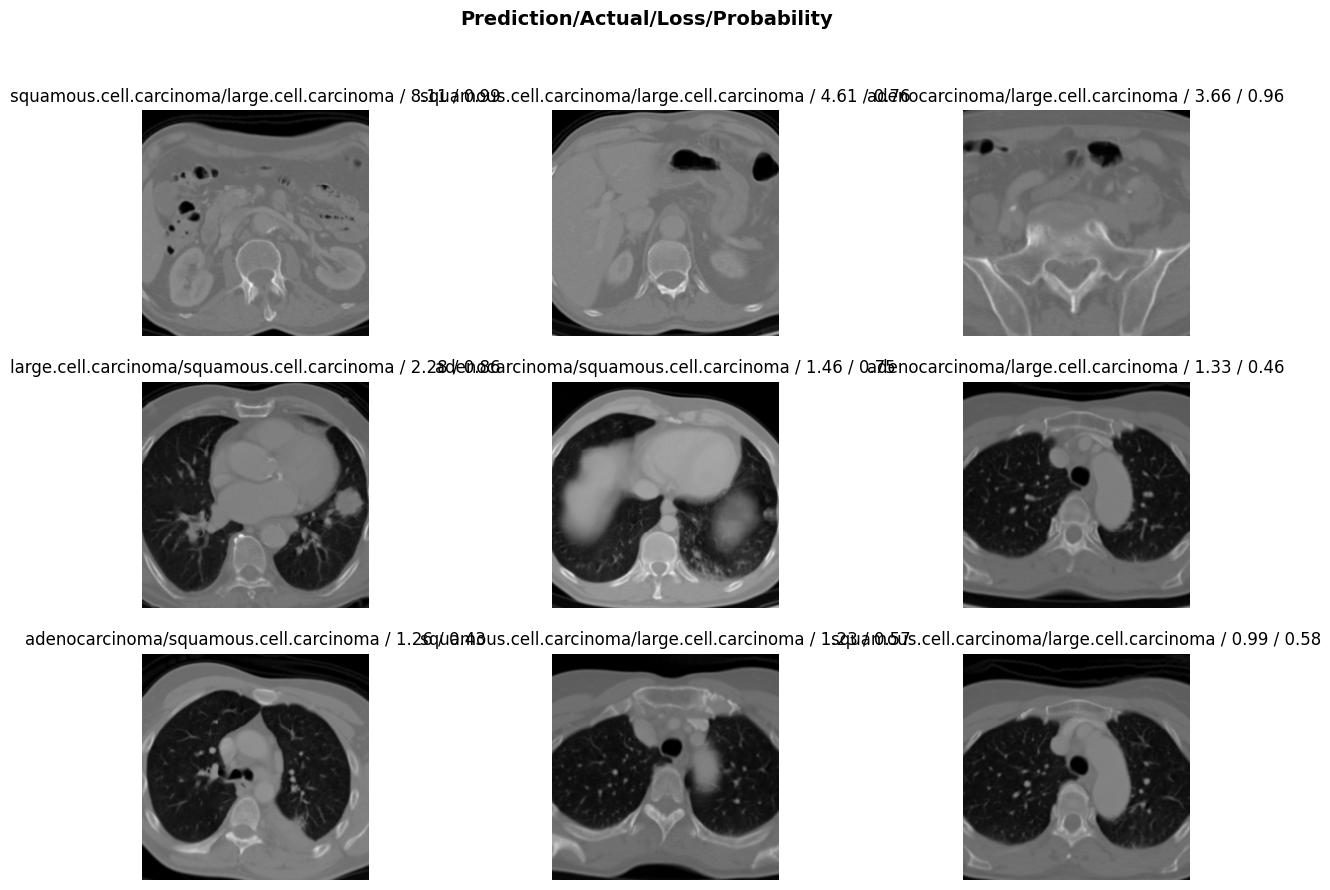

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
file_names = get_image_files(path)
img = PILImage.create(file_names[random.randint(0, len(file_names)) - 1])

prediction,_,probs = learn.predict(img)

print(f"Predicted picture: {prediction}.")
print(f"Probability: {probs[1].item():.6f}")
img.to_thumb(192)